## Instalacja Wandb i Simple Transformers

In [ ]:
!pip install wandb -qqq
!pip install -q simpletransformers
!pip install scikit-learn

import matplotlib.pyplot as plt
import wandb
import pandas as pd
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Przygotowanie danych


                                                text  labels
0  Dla mnie faworytem do tytułu będzie Cracovia. ...       0
1  @anonymized_account @anonymized_account Brawo ...       0
2  @anonymized_account @anonymized_account Super,...       0
3  @anonymized_account @anonymized_account Musi. ...       0
4    Odrzut natychmiastowy, kwaśna mina, mam problem       0
Value count:
0    9190
2     598
1     253
Name: labels, dtype: int64
                                                text  labels
0  Dla mnie faworytem do tytułu będzie Cracovia Z...       0
1         Brawo ty Daria kibic ma być na dobre i złe       0
2    Super polski premier składa kwiaty na grobac...       0
3                          Musi Innej drogi nie mamy       0
4      Odrzut natychmiastowy kwaśna mina mam problem       0
0    850
2    103
1     47
Name: labels, dtype: int64
                                                text  labels
0       Patrząc na polską prawicę jest się od kog...       0
1   I to będzie dobre 

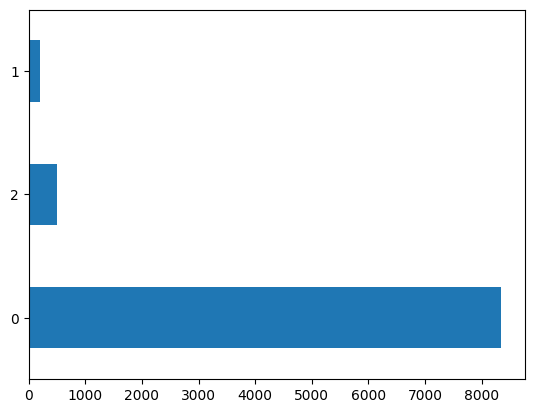

In [ ]:
#plik z tekstem
text_training = pd.read_csv('/content/training_set_clean_only_text.txt', header = None, delimiter = '\t')

#plik z klasyfikacją (0,1,2)
tags_training = pd.read_csv('/content/training_set_clean_only_tags.txt', header = None, delimiter = '\t')

#połączenie obu plików
df = pd.concat([text_training, tags_training], axis = 1)
df.columns = ['text', 'labels']

print(df.head())

print("Value count:")
print(df['labels'].value_counts())

#próba czyszczenia
'''
def preprocess_dataframe(df):
    df['text'] = df['text'].apply(lambda x: x.replace('@anonymized_account', ''))
    df['text'] = df['text'].apply(lambda x: x.replace('RT', ''))
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s\d\s]+', '', x))

    return df

df = preprocess_dataframe(df)
'''

#podzielenie danych (1000 na ewaluacje z treningowych)
training_df = df.iloc[:-1000]
eval_df = df.iloc[-1000:]
eval_df = eval_df.reset_index(drop=True)

#podgląd na dane treningowe
training_df['labels'].value_counts().plot(kind='barh')
print(training_df.head())


print(eval_df['labels'].value_counts())
print(eval_df.head())

#plik z tekstem
text_test = pd.read_csv('/content/test_set_only_text.txt', header = None, delimiter = '\t')

#plik z klasyfikacją (0,1,2)
tags_test = pd.read_csv('/content/test_set_only_tags.txt', header = None, delimiter = '\t')

#połączenie obu plików
test_df = pd.concat([text_test, tags_test], axis = 1)
test_df.columns = ['text', 'labels']

print(test_df.head())

print("Value count:")
print(test_df['labels'].value_counts())

#test_df = preprocess_dataframe(df1)
#print(test_df.head())

In [ ]:

print("Value count for test data:")
print(test_df['labels'].value_counts())

Value count for test data:
0    866
2    109
1     25
Name: labels, dtype: int64


In [ ]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Trenowanie modelu

In [ ]:
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, recall_score,precision_score, accuracy_score

def metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

#argumenty do treningu
train_args = {
    'learning_rate': 1e-3,
    'evaluate_during_training': True, #musi byc true
    'num_train_epochs': 2,
    'save_eval_checkpoints': False, #lepiej na false
    'train_batch_size': 32,
    'eval_batch_size': 32,
    'overwrite_output_dir': True, #outputs w plikach obok
    'wandb_project': "hatespeech_training"
}

#inicjalizacja wandb
wandb.init(project=train_args['wandb_project'])

#stworzenie modelu klasyfikacji
model = ClassificationModel('distilbert', 'distilbert-base-cased', num_labels=3, use_cuda=False, cuda_device=0, args=train_args)

#trenowanie modelu
model.train_model(training_df, eval_df = eval_df, eval_metrics = metrics)
result, model_outputs, wrong_predictions = model.eval_model(test_df)


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

  0%|          | 0/9041 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running Epoch 1 of 2:   0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

Training loss,▃▂▃▄▂▃▃▃▃█▁
eval_loss,▁█
global_step,▁▂▂▃▄▄▄▅▆▆▇██
lr,█▇▇▆▅▅▄▃▂▂▁
mcc,▁▁
train_loss,█▁
Training loss,0.07635
eval_loss,0.54465
global_step,566
lr,3e-05
mcc,0.0


## Użycie TD-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#stworzenie TF-IDF Vectorizer
vect = TfidfVectorizer()

#dopasowanie do danych treningowych
training_vectors = vect.fit_transform(training_df['text'])

#zamiana danych eval na wektory TF-IDF
eval_vectors = vect.transform(eval_df['text'])

#stworzenie instancji klasyfikatora
klasyfikator = LogisticRegression()

#trenowanie klasyfikatora używając wektorów TF-IDF i etykier
klasyfikator.fit(training_vectors, training_df['labels'])

#predictions na wektorach eval
predictions = klasyfikator.predict(eval_vectors)

#policzenie F1, accuracy, precision i recall porównując predicated labels i prawdziwe
f1 = f1_score(eval_df['labels'], predictions, average='weighted')
acc = accuracy_score(eval_df['labels'], predictions)
prec = precision_score(eval_df['labels'], predictions, average='weighted')
recall = recall_score(eval_df['labels'], predictions, average='weighted')

print("F1:", f1)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", recall)

F1: 0.7892922844235707
Accuracy: 0.853
Precision: 0.7783611670020122
Recall: 0.853


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
